In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow --quiet

In [3]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [4]:
# Read in the Platinum dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

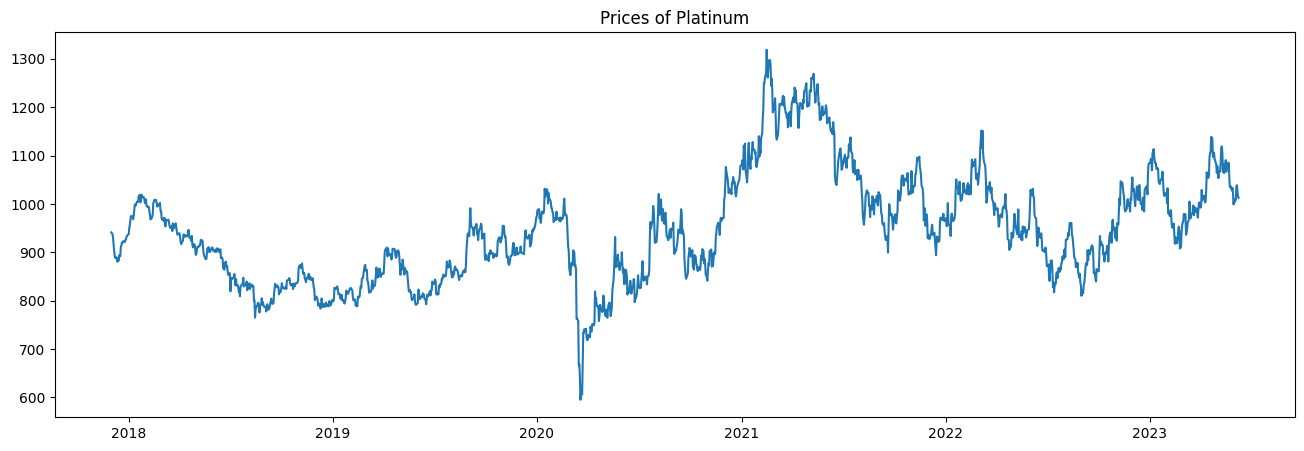

In [5]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Platinum')
plt.show()

# Split dataset (7-2-1)

---



In [6]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [8]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [9]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [10]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.09837, saving model to save_model(7-2-1).hdf5
24/24 - 2s - loss: 0.0984 - 2s/epoch - 90ms/step
Epoch 2/80

Epoch 2: loss improved from 0.09837 to 0.03431, saving model to save_model(7-2-1).hdf5
24/24 - 0s - loss: 0.0343 - 112ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: loss improved from 0.03431 to 0.02737, saving model to save_model(7-2-1).hdf5
24/24 - 0s - loss: 0.0274 - 114ms/epoch - 5ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02737 to 0.02557, saving model to save_model(7-2-1).hdf5
24/24 - 0s - loss: 0.0256 - 110ms/epoch - 5ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02557 to 0.02516, saving model to save_model(7-2-1).hdf5
24/24 - 0s - loss: 0.0252 - 112ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss improved from 0.02516 to 0.02405, saving model to save_model(7-2-1).hdf5
24/24 - 0s - loss: 0.0241 - 136ms/epoch - 6ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02405 to 0.02242, saving model to save_model(7-2-1).hdf5
24/24 -

In [11]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

38/38 [==============================] - 1s 2ms/step


In [12]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

11/11 [==============================] - 0s 4ms/step


In [13]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

6/6 [==============================] - 0s 5ms/step


In [14]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input.shape)
        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
[[0.5836191177368164], [0.5914555788040161], [0.5985866189002991], [0.6045918464660645], [0.6100592613220215], [0.6155182719230652], [0.621120035648346], [0.6268724203109741], [0.6327151656150818], [0.6386056542396545], [0.6445325016975403], [0.6504964828491211], [0.6565021872520447], [0.6625517010688782], [0.6686445474624634], [0.6747792363166809], [0.6809539794921875], [0.6871675848960876], [0.6934185028076172], [0.6997052431106567], [0.7060266137123108], [0.7123813033103943], [0.7187675833702087], [0.7251840233802795], [0.7316290736198425], [0.7381010055541992], [0.7445983290672302], [0.7511187195777893], [0.7576611638069153], [0.7642234563827515]]


In [15]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

<Figure size 1600x500 with 0 Axes>

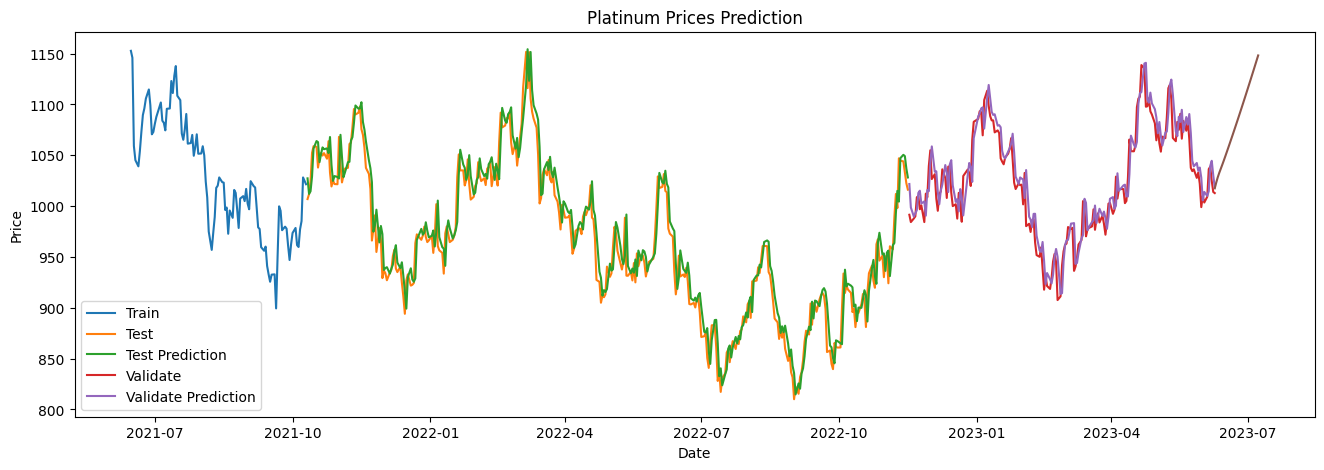

In [16]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [17]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [18]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  14.263996055313873
MAPE:  1.484282266128696
RMSE:  18.403180239912086

** Validate **
MAE:  13.934566784456292
MAPE:  1.3658270461913642
RMSE:  17.927512553595104


# Split dataset (6-3-1)

---



In [19]:
# Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [21]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [22]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(6-3-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.03613, saving model to save_model(6-3-1).hdf5
21/21 - 3s - loss: 0.0361 - 3s/epoch - 123ms/step
Epoch 2/80

Epoch 2: loss improved from 0.03613 to 0.02390, saving model to save_model(6-3-1).hdf5
21/21 - 0s - loss: 0.0239 - 106ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: loss improved from 0.02390 to 0.02214, saving model to save_model(6-3-1).hdf5
21/21 - 0s - loss: 0.0221 - 109ms/epoch - 5ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02214 to 0.01982, saving model to save_model(6-3-1).hdf5
21/21 - 0s - loss: 0.0198 - 126ms/epoch - 6ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01982 to 0.01862, saving model to save_model(6-3-1).hdf5
21/21 - 0s - loss: 0.0186 - 119ms/epoch - 6ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.01862
21/21 - 0s - loss: 0.0187 - 82ms/epoch - 4ms/step
Epoch 7/80

Epoch 7: loss did not improve from 0.01862
21/21 - 0s - loss: 0.0201 - 95ms/epoch - 5ms/step
Epoch 8/80

Epoch 8: loss did not improve fro

In [23]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(6-3-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 [==============================] - 0s 2ms/step


In [24]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

17/17 [==============================] - 0s 2ms/step


In [25]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

6/6 [==============================] - 0s 3ms/step


In [26]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.5782154202461243], [0.5801771879196167], [0.581741213798523], [0.5827128291130066], [0.5835726261138916], [0.5844017267227173], [0.585259199142456], [0.5861456394195557], [0.5870394110679626], [0.5879365801811218], [0.5888345837593079], [0.5897337794303894], [0.5906350612640381], [0.5915386080741882], [0.592444658279419], [0.5933529734611511], [0.5942636132240295], [0.5951763987541199], [0.5960912108421326], [0.5970081686973572], [0.5979273319244385], [0.598848819732666], [0.5997723340988159], [0.6006978750228882], [0.6016255617141724], [0.602555513381958], [0.6034873723983765], [0.6044213771820068], [0.6053573489189148], [0.6062953472137451]]


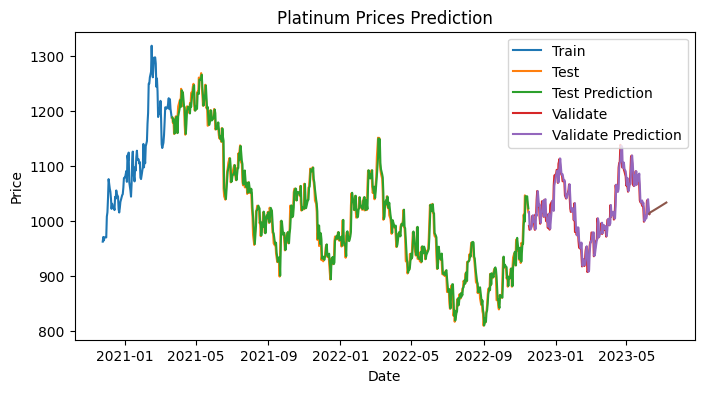

In [27]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(8, 4))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [28]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.6517899537318
MAPE:  1.3644951067051525
RMSE:  17.830605481100783

** Validate **
MAE:  13.061436859307264
MAPE:  1.2789679373879825
RMSE:  17.1203863013534


# Split dataset (5-3-2)

---



In [29]:
# Split data (5-3-2)
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [30]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [31]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [32]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(5-3-2).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.19890, saving model to save_model(5-3-2).hdf5
18/18 - 1s - loss: 0.1989 - 1s/epoch - 58ms/step
Epoch 2/80

Epoch 2: loss improved from 0.19890 to 0.04431, saving model to save_model(5-3-2).hdf5
18/18 - 0s - loss: 0.0443 - 67ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.04431 to 0.02537, saving model to save_model(5-3-2).hdf5
18/18 - 0s - loss: 0.0254 - 65ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02537 to 0.01901, saving model to save_model(5-3-2).hdf5
18/18 - 0s - loss: 0.0190 - 72ms/epoch - 4ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01901 to 0.01695, saving model to save_model(5-3-2).hdf5
18/18 - 0s - loss: 0.0169 - 76ms/epoch - 4ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.01695
18/18 - 0s - loss: 0.0191 - 46ms/epoch - 3ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01695 to 0.01661, saving model to save_model(5-3-2).hdf5
18/18 - 0s - loss: 0.0166 - 69ms/epoch - 4ms/step
Epoch 

In [33]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(5-3-2).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

27/27 [==============================] - 0s 3ms/step


In [34]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

17/17 [==============================] - 0s 2ms/step


In [35]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

11/11 [==============================] - 0s 3ms/step


In [36]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.5775037407875061], [0.578094482421875], [0.5785844326019287], [0.5789461135864258], [0.5792850852012634], [0.5796133279800415], [0.57993483543396], [0.5802494883537292], [0.5805565118789673], [0.5808560848236084], [0.5811482667922974], [0.5814331769943237], [0.5817111134529114], [0.5819821357727051], [0.5822465419769287], [0.5825043320655823], [0.5827556848526001], [0.5830008387565613], [0.5832399129867554], [0.5834729075431824], [0.5837001800537109], [0.5839217901229858], [0.5841378569602966], [0.5843485593795776], [0.5845540165901184], [0.5847541689872742], [0.5849493145942688], [0.5851395726203918], [0.5853250622749329], [0.5855057835578918]]


<Figure size 1600x500 with 0 Axes>

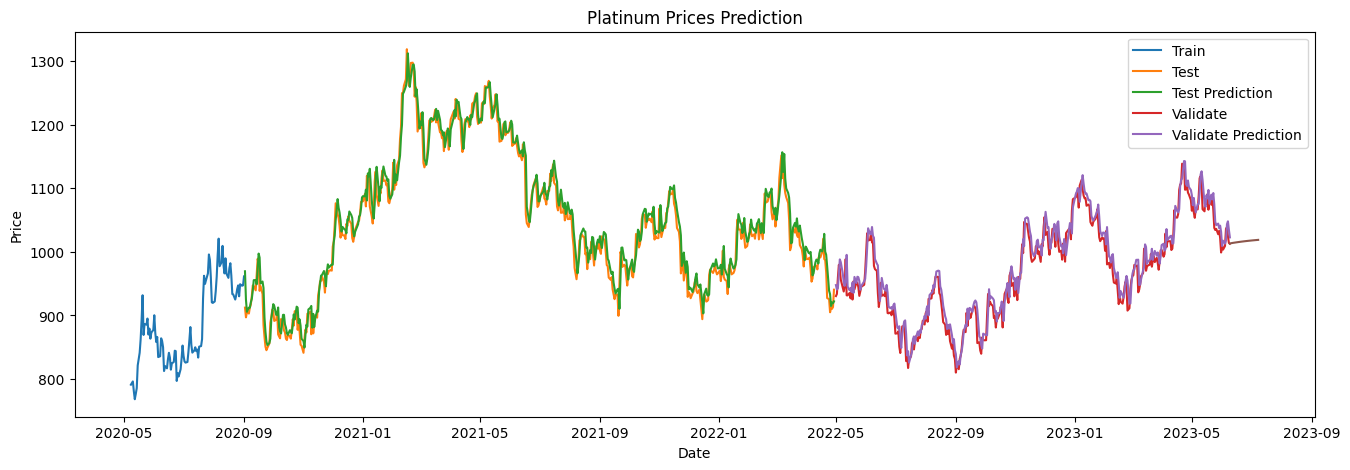

In [37]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [38]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  15.773442122079798
MAPE:  1.5281327140150498
RMSE:  20.246811014136007

** Validate **
MAE:  15.274679175088576
MAPE:  1.5851115357251377
RMSE:  19.069626398791502


# Evaluating model

---

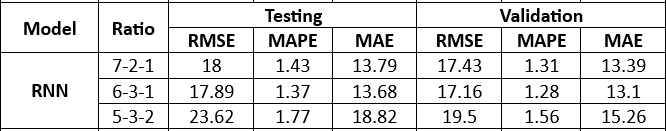